# WeatherPy


In [259]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import scipy.stats as st
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
import requests
import json
from pprint import pprint
from datetime import datetime

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

#Set todays date to include in plots
dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%d-%b-%Y")


## Generate Cities List

- Generate 1500 random latitude and longitude pairs
- Use citypy to find the cities nearest those lat/long coordinates. Note this may result in the same city being nearest to more than one of the lat/long coords. In this case the city is ignored. So the final list of cities may be fewerr than the number of random lat/long coords generated.
- Output is a list of cities with their country and the lat/long coords that produced that city from citipy. Note that these lat/long coords are not the actual lat/long coords of the city on a map. These will be found from the OpenWeather API in the nest step.

In [260]:
#Initialize empty lists for: Lat/Lng pairs, cities, countries, latitude, and longitude (the original pairs used to find the "nearest city"). Note this is NOT the actual lat/lng of the city, this is captured later from the OpenWeather API

lat_lngs = []
cities = []
countries=[]
orig_latitude=[]
orig_longitude=[]


# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)

#Zip lat and lon for use by citypy call
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination using citipy
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    country = citipy.nearest_city(lat_lng[0], lat_lng[1]).country_code
    #Check to ensure no duplicates
    if city not in cities:
        cities.append(city)
        countries.append(country)
        orig_latitude.append(lat_lng[0])
        orig_longitude.append(lat_lng[1])

#Zip city, country, lat, lon for use in Open Weather API call together for use in city
city_country_lat_lon = zip(cities, countries, orig_latitude, orig_longitude)

### Perform API Calls

- Use OpenWeather API to get the current weather for each city generated in the previous step.
- Not all cites generated previously can be found in OpenWeather API. If response code is not 200 (meaning the city was not found) skip this city.
- Create lists of all the relevant data for the cities that are found including:
- City ID
- City name
- City country
- Original Latitude which was used in citypy
- Original Longitude which was used in city py
- Current temperature from OpenWeather (in F)
- Current humidity from OpenWeather
- Current cloudiness from OpenWeather (in percent)
- Current wind speed from OpenWeather
- Actual latitude of the city from OpenWeather (to be used in plotting)
- Actual Longitude of the city from OpenWeather (to be used in plotting)

Since processing many API calls takes time, a progress indicator is printed out while the cities are being processed through OpenWeather API.

In [261]:
#Example of OpenWeather API call http://api.openweathermap.org/data/2.5/weather?q=London,uk&APPID=973d76a9421d572f47622e44bcca1876
#http://api.openweathermap.org/data/2.5/weather?q={city name},{state},{country code}&units=imperial&appid={your api key}


#Initialize lists to capture the stats for each city
city_ID=[]
city_temp=[]
city_humidity=[]
city_clouds_pct=[]
city_windspeed=[]

#These are the actual lat and lon for the city (not those used in find the nearest city in citipy)
city_latitude=[]
city_longitude=[]
cities = []
countries=[]

#These are the orig lat and lon used by citipy to find the nearest city. Captured just for comparison with the actual.
orig_latitude=[]
orig_longitude=[]

#Loop through all the cities captured by citipy
for city_loop, country_loop, lat_loop, lon_loop in city_country_lat_lon:
    city_name = city_loop
    country_name = country_loop
    #Set the URL using the city, country, api key
    url = 'http://api.openweathermap.org/data/2.5/weather?q='+city_name+',,'+country_name+'&units=imperial&appid='+weather_api_key
    
    #Capture the request from OpenWeather API
    res = requests.get(url)
    #Check to ensure the response is valid, if not go to the next item in the for loop
    if res.status_code != 200:
        #Print a progress indicator to the screen    
        print(city_name+' not found at OpenWeather API!')
        continue
    #Capture the valid response in json
    response = res.json()
    #Print a progress indicator to the screen
    print(str(response['id'])+": "+city_name+' found and added!')
    
    #Append values to all the various lists to capture the city data
    city_ID.append(response['id'])
    cities.append(city_name)
    countries.append(country_name)
    orig_latitude.append(lat_loop)
    orig_longitude.append(lon_loop)
    city_temp.append(response['main']['temp'])
    city_humidity.append(response['main']['humidity'])
    city_clouds_pct.append(response['clouds']['all'])
    city_windspeed.append(response['wind']['speed'])
    city_latitude.append(response['coord']['lat'])
    city_longitude.append(response['coord']['lon'])

#Print an indicator that the Open Weather API and data capture process has finished
print('')
print('FINISHED PROCESSING WEATHER APIs')

17: campbellsville found and added!
taolanaro not found at OpenWeather API!
986717: kruisfontein found and added!
2136825: isangel found and added!
1181022: chor found and added!
6170031: tuktoyaktuk found and added!
2192093: coromandel found and added!
illoqqortoormiut not found at OpenWeather API!
110690: faya found and added!
3423146: ilulissat found and added!
2121385: severo-kurilsk found and added!
amderma not found at OpenWeather API!
5606187: saint anthony found and added!
4020109: atuona found and added!
317844: cumra found and added!
2270385: camacha found and added!
tsihombe not found at OpenWeather API!
8079926: labuhan found and added!
1512019: aksarka found and added!
2206939: bluff found and added!
3471451: arraial do cabo found and added!
3374333: praia found and added!
sorvag not found at OpenWeather API!
964420: port elizabeth found and added!
544397: kortkeros found and added!
1215502: banda aceh found and added!
3533462: acapulco found and added!
2411397: georgetown

### Convert Raw Data to DataFrame


In [262]:
#Build the dataframe of all the city records and data

city_data = pd.DataFrame(columns=['City ID', 'City', 'Country', 'Orig Lat', 'Orig Lon', 'Act Lat', 'Act Lon', 'Temperature (F)', 'Humidity', 'Cloudiness', 'Wind Speed'])

city_data['City ID'] = city_ID
city_data['City'] = cities
city_data['Country'] = countries
city_data['Orig Lat'] = orig_latitude
city_data['Orig Lon'] = orig_longitude
city_data['Act Lat'] = city_latitude
city_data['Act Lon'] = city_longitude
city_data['Temperature (F)'] = city_temp
city_data['Humidity'] = city_humidity
city_data['Cloudiness'] = city_clouds_pct
city_data['Wind Speed'] = city_windspeed

city_data.set_index('City ID', inplace=True)
#Print the dataframe to screen and csv file
print('The total number of cities added is '+str(len(city_data)))
city_data.head()

The total number of cities added is 549


,City,Country,Orig Lat,Orig Lon,Act Lat,Act Lon,Temperature (F),Humidity,Cloudiness,Wind Speed
City ID,,,,,,,,,,
1106677,bambous virieux,mu,-30.126818,72.237379,-20.34,57.76,76.53,94,75,16.11
4021858,guerrero negro,mx,20.395875,-122.074178,27.98,-114.06,67.98,46,0,10.36
5855927,hilo,us,17.975979,-143.756263,19.73,-155.09,75.88,61,20,4.70
3833367,ushuaia,ar,-54.405780,-51.326204,-54.80,-68.30,57.20,58,40,12.75
2151187,roma,au,-25.999736,146.301871,-26.58,148.78,63.63,67,61,10.85


## Inspect the data and remove the cities where the humidity > 100%. Produce final clean city df without humidity outliers. Save as CSV.
----


In [263]:
#  Get the indices of cities that have humidity over 100%.
crazy_humid_cities = city_data.loc[city_data['Humidity']>100]

# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
#make a copy of the city_data DataFrame, which we call "clean_city_data".
clean_city_data = city_data.loc[city_data['Humidity']<=100]

#Delete the Orig Lat and Orig Lon as these are not the actual lat and lon of the city. Delete Act Lon since plotting is on Act Lat. Keep the city, country, and ID fields.
del clean_city_data['Orig Lat']
del clean_city_data['Orig Lon']
del clean_city_data['Act Lon']

north_city_data = clean_city_data.loc[clean_city_data['Act Lat']>=0]
south_city_data = clean_city_data.loc[clean_city_data['Act Lat']<0]

# Export the City_Data and Clean_city_data into csv's
city_data.to_csv('output_data/city_data.csv')
clean_city_data.to_csv('output_data/clean_city_data.csv')

clean_city_count = clean_city_data['City'].count()
print(clean_city_count)
clean_city_data.head()

549


,City,Country,Act Lat,Temperature (F),Humidity,Cloudiness,Wind Speed
City ID,,,,,,,
1106677,bambous virieux,mu,-20.34,76.53,94,75,16.11
4021858,guerrero negro,mx,27.98,67.98,46,0,10.36
5855927,hilo,us,19.73,75.88,61,20,4.70
3833367,ushuaia,ar,-54.80,57.20,58,40,12.75
2151187,roma,au,-26.58,63.63,67,61,10.85


## Plotting the Data and Linear Regression
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

###Function to return scatter plot and optional linear regression plat and file path/name for saving

In [264]:
def get_line(x,y,x_name,y_name, incl_regress):
    
    ax1=[]
    ax2=[]
    city_count = x.count()
    ax1=plt.scatter(x,y)
    ax1=plt.title(f'{city_count} cities on {timestampStr}: {y_name} vs. {x_name}')
    ax1=plt.xlabel(x_name)
    ax1=plt.ylabel(f'{y_name}')

    if incl_regress:
        slope, intercept, rvalue, pvalue, stderr = st.linregress(x,y)
        r_squared = rvalue**2
        ax2=plt.plot(x, x*slope+intercept, color='red', label= 'Y= '+str(round(slope,2))+'*X + '+str(round(intercept,2))+' R2='+str(round(r_squared,2)))
        ax2=plt.legend()
    if min(x)<0:
        if max(x)>0:
            hem='Global'
            ax1 = plt.xlim(-60, 90)
        else:
            hem='South'
            ax1 = plt.xlim(-60, 0)
    else:
        hem='North'
        ax = plt.xlim(0,90)
    
    png_file = 'output_data/'+y_name+'_'+x_name+'_'+hem+'.png'

    return ax1, ax2, png_file

## Latitude vs. Temperature Plot

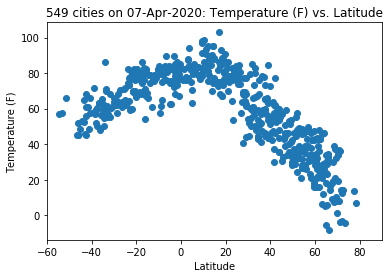

In [265]:
graph1, graph2, png_file = get_line(clean_city_data['Act Lat'], clean_city_data['Temperature (F)'], 'Latitude', 'Temperature (F)', False)
plt.savefig(png_file)
plt.show()

## Latitude vs. Humidity Plot

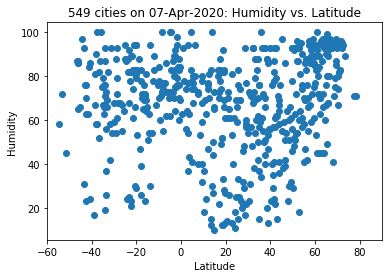

In [266]:
graph1, graph2, png_file = get_line(clean_city_data['Act Lat'], clean_city_data['Humidity'], 'Latitude', 'Humidity', False)
plt.savefig(png_file)
plt.show()

## Latitude vs. Cloudiness Plot

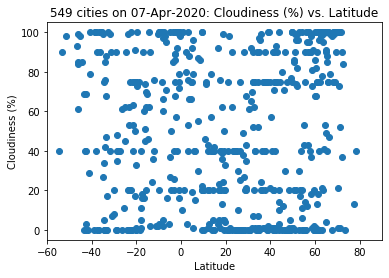

In [267]:
graph1, graph2, png_file = get_line(clean_city_data['Act Lat'], clean_city_data['Cloudiness'], 'Latitude', 'Cloudiness (%)', False)
plt.savefig(png_file)
plt.show()

## Latitude vs. Wind Speed Plot

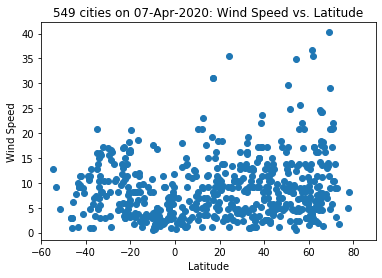

In [268]:
graph1, graph2, png_file = get_line(clean_city_data['Act Lat'], clean_city_data['Wind Speed'], 'Latitude', 'Wind Speed', False)
plt.savefig(png_file)
plt.show()

## Northern Hemisphere - Latitude vs. Temperature Plot 

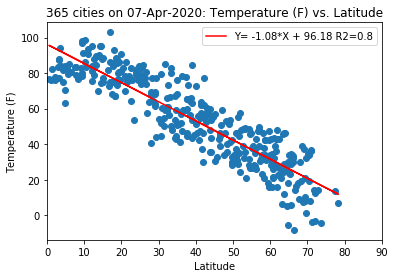

In [269]:
graph1, graph2, png_file = get_line(north_city_data['Act Lat'], north_city_data['Temperature (F)'], 'Latitude', 'Temperature (F)', True)
plt.savefig(png_file)
plt.show()

## Southern Hemisphere - Latitude vs. Temperature Plot 

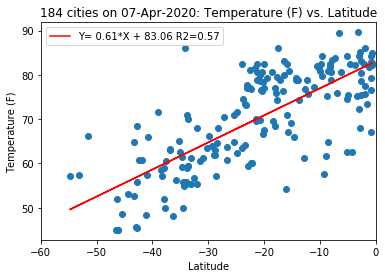

In [270]:
graph1, graph2, png_file = get_line(south_city_data['Act Lat'], south_city_data['Temperature (F)'], 'Latitude', 'Temperature (F)', True)
plt.savefig(png_file)
plt.show()

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

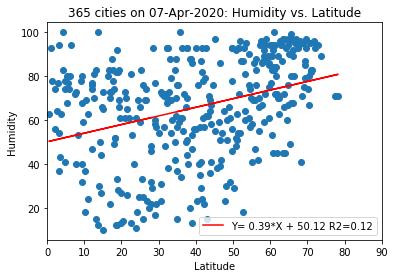

In [271]:
graph1, graph2, png_file = get_line(north_city_data['Act Lat'], north_city_data['Humidity'], 'Latitude', 'Humidity', True)
plt.savefig(png_file)
plt.show()

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

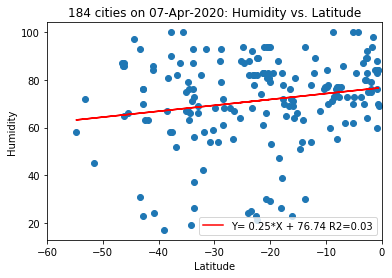

In [272]:
graph1, graph2, png_file = get_line(south_city_data['Act Lat'], south_city_data['Humidity'], 'Latitude', 'Humidity', True)
plt.savefig(png_file)
plt.show()

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

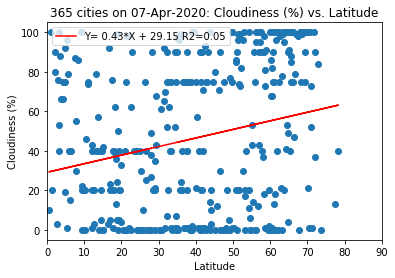

In [273]:
graph1, graph2, png_file = get_line(north_city_data['Act Lat'], north_city_data['Cloudiness'], 'Latitude', 'Cloudiness (%)', True)
plt.savefig(png_file)
plt.show()

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

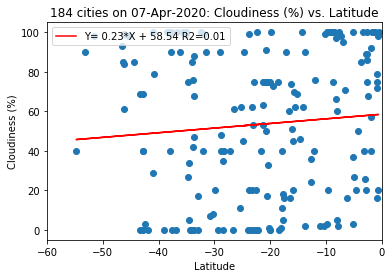

In [274]:
graph1, graph2, png_file = get_line(south_city_data['Act Lat'], south_city_data['Cloudiness'], 'Latitude', 'Cloudiness (%)', True)
plt.savefig(png_file)
plt.show()

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

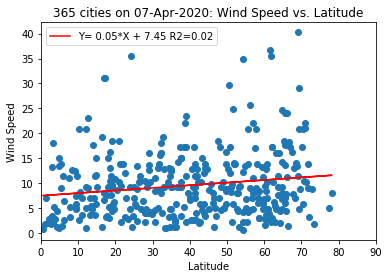

In [275]:
graph1, graph2, png_file = get_line(north_city_data['Act Lat'], north_city_data['Wind Speed'], 'Latitude', 'Wind Speed', True)
plt.savefig(png_file)
plt.show()

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

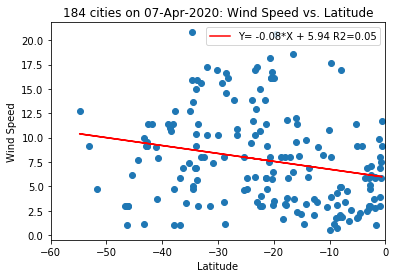

In [276]:
graph1, graph2, png_file = get_line(south_city_data['Act Lat'], south_city_data['Wind Speed'], 'Latitude', 'Wind Speed', True)
plt.savefig(png_file)
plt.show()